# Predicting Democratic Backsliding

## Import Packages

In [42]:
# Data Wrangling
import pandas as pd
import numpy as np
import country_converter as coco
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Model Interpretation
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
from sklearn.inspection import permutation_importance
from pdpbox import pdp

## Load the democracy data and select features

In [43]:
vdem = pd.read_csv("Data/Country_Year_V-Dem_Full+others_CSV_v10/V-Dem-CY-Full+Others-v10.csv")

In [44]:
vdem = vdem.loc[vdem['year'] >= 1960]

In [45]:
civil_liberties = vdem[["country_name", "year", "v2x_frassoc_thick", "v2x_suffr", "v2xel_frefair", "v2cltort", "v2clkill", "v2cltrnslw", "v2clrspct", "v2clacjust", "v2clsocgrp", "v2clacfree", "v2clrelig", "v2caassemb", "v2xcl_acjst", "v2x_clpol", "v2x_freexp"]]

In [46]:
civil_society = vdem[["country_name", "year", "v2x_cspart", "v2cseeorgs", "v2csreprss", "v2cscnsult", "v2csstruc_0", "v2csstruc_1", "v2csstruc_2", "v2csprtcpt", "v2csantimv", "v2csrlgrep"]]

In [47]:
media = vdem[["country_name", "year", "v2mecenefm", "v2mecenefi", "v2mecenefibin", "v2mecrit", "v2merange", "v2meharjrn", "v2mebias"]]

In [48]:
access_services = vdem[["country_name", "year", "v2pepwrses", "v2pepwrsoc", "v2peedueq", "v2pehealth", "v2peapsecon", "v2peasjsoecon", "v2peasbecon", "v2clgencl", "v2peapsgen", "v2pepwrgeo", "v2clgeocl", "v2peapsgeo", "v2peasjgeo", "v2peasbegeo", "v2clpolcl", "v2peapspol", "v2peasjpol", "v2peasbepol"]]

In [49]:
strife = vdem[["country_name", "year", "v2cacamps", "v2caviol", "v2cagenmob", "v2cademmob", "v2caautmob", "v2castate", "v2catrauni", "v2capolit", "v2canonpol"]]

In [50]:
polity_data = pd.read_csv("Data/p5v2018.csv")

In [51]:
polity_data = polity_data[["country", "year", "polity2", "durable"]]

In [52]:
polity_data = polity_data.loc[polity_data['year'] >= 1960]

In [53]:
polity_data

,country,year,polity2,durable
160,Afghanistan,1960,-10.0,NaN
161,Afghanistan,1961,-10.0,NaN
162,Afghanistan,1962,-10.0,NaN
163,Afghanistan,1963,-10.0,NaN
164,Afghanistan,1964,-7.0,0.0
...,...,...,...,...
17543,Zimbabwe,2014,4.0,1.0
17544,Zimbabwe,2015,4.0,2.0
17545,Zimbabwe,2016,4.0,3.0
17546,Zimbabwe,2017,4.0,4.0


## Load the econ data (what if we make this SOL data- life expectacny etc)

In [54]:
# read in GDP per capita growth data
GDPPC_growth = pd.read_csv("Data/gdp_per_capita_yearly_growth.csv")

In [55]:
# melt so that we have country year as units of observation
GDPPC_growth = GDPPC_growth.melt(id_vars= 'country', var_name = 'year', value_name='GDPpc_growth')

In [56]:
# change year to numeric
GDPPC_growth['year'] = pd.to_numeric(GDPPC_growth['year'])

In [57]:
# keep only observations from 1960 onwards
GDPPC_growth = GDPPC_growth.loc[GDPPC_growth['year'] >= 1960]

In [58]:
# read in real GDP growth data
GDP_growth = pd.read_csv("Data/gdp_total_yearly_growth.csv")

In [59]:
# melt so that we have country year as units of observation
GDP_growth = GDP_growth.melt(id_vars= 'country', var_name = 'year', value_name='GDP_growth')

In [60]:
# change year to numeric
GDP_growth['year'] = pd.to_numeric(GDP_growth['year'])

In [61]:
# keep only observations from 1960 onwards
GDP_growth = GDP_growth.loc[GDP_growth['year'] >= 1960]

## Make sure countries line up

In [62]:
len(np.intersect1d(GDP_growth.country, GDP_growth.country))

194

In [63]:
len(GDP_growth.country.unique())

194

In [64]:
len(vdem.country_name.unique())
# vdems has less countries than gapminder and GDP

182

In [65]:
len(polity_data.country.unique())

180

In [66]:
#civil_liberties['country_name'] = civil_liberties.country_name.apply(lambda x: coco.convert(names=x, to='name_short'))

In [67]:
# standardize country names with country-converter than keep the countries that overlap
vdem_names = civil_liberties.country_name.to_list()
vdem_names = coco.convert(vdem_names, to = 'name_short', not_found = None)

Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
Republic of Vietnam not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German Democratic Republic not found in regex
German D

In [68]:
polity_names = polity_data.country.tolist()
polity_names = coco.convert(polity_names, to = 'name_short')

Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Vietnam North not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found in regex
Germany East not found 

In [69]:
polity_data["country"] = polity_names
access_services["country_name"] = vdem_names
civil_liberties["country_name"] = vdem_names
civil_society["country_name"] = vdem_names
media["country_name"] = vdem_names
strife["country_name"] = vdem_names

In [70]:
polity_names = pd.Series(polity_names)
vdem_names = pd.Series(vdem_names)

In [71]:
intersection = pd.Series(np.intersect1d(polity_names, vdem_names))

In [72]:
polity_data = polity_data[polity_data["country"].isin(intersection)]
access_services = access_services[access_services["country_name"].isin(intersection)]
civil_liberties = civil_liberties[civil_liberties["country_name"].isin(intersection)]
civil_society = civil_society[civil_society["country_name"].isin(intersection)]
media = media[media["country_name"].isin(intersection)]
strife = strife[strife["country_name"].isin(intersection)]

## Wrangle institution data

In [73]:
# Set country and year as index for X variables
# should I combine the two or should I set a multi index
access_services.set_index(["country_name", "year"], inplace=True)
civil_liberties.set_index(["country_name", "year"], inplace=True)
civil_society.set_index(["country_name", "year"], inplace=True)
media.set_index(["country_name", "year"], inplace=True)
strife.set_index(["country_name", "year"], inplace=True)

In [74]:
# lag variables- previous year
strife = strife.groupby("country_name").shift()
media = media.groupby("country_name").shift()

In [75]:
# for the y let's drop durable for now
polity_data.drop(columns = "durable", inplace=True)

In [76]:
# Create variable to show change in polity score
shifted_polity = polity_data.groupby("country").apply(lambda x: x - x.shift(1))

In [77]:
polity_data["change in polity"] = shifted_polity.polity2

In [78]:
# create binary variable for presence of backsliding
polity_data["backsliding"] = np.where(polity_data["change in polity"] >= 0, 0, 1) 

In [79]:
# set country year index for Y
polity_data.set_index(["country", "year"], inplace=True)

In [80]:
polity_data

polity2  change in polity  backsliding
country     year                                        
Afghanistan 1960    -10.0               NaN            1
            1961    -10.0               0.0            0
            1962    -10.0               0.0            0
            1963    -10.0               0.0            0
            1964     -7.0               3.0            0
...                   ...               ...          ...
Zimbabwe    2014      4.0               0.0            0
            2015      4.0               0.0            0
            2016      4.0               0.0            0
            2017      4.0               0.0            0
            2018      4.0               0.0            0

[8575 rows x 3 columns]

In [81]:
polity_data.drop(columns = ["polity2", "change in polity"], inplace=True)

In [82]:
# Merge Data
strife = polity_data.merge(strife, how = "inner", left_index = True, right_on = ['country_name', 'year'])

In [83]:
strife

backsliding  v2cacamps  v2caviol  v2cagenmob  v2cademmob  \
country_name year                                                             
Afghanistan  1960            1        NaN       NaN         NaN         NaN   
             1961            0        NaN       NaN         NaN         NaN   
             1962            0        NaN       NaN         NaN         NaN   
             1963            0        NaN       NaN         NaN         NaN   
             1964            0        NaN       NaN         NaN         NaN   
...                        ...        ...       ...         ...         ...   
Zimbabwe     2014            0      2.124     1.780       2.116       1.438   
             2015            0      2.598     1.695       2.116       1.106   
             2016            0      2.598     1.695       2.371       1.106   
             2017            0      3.005     1.984       2.876       2.597   
             2018            0      2.951     1.982       3.422       2.597   

                   v2caautmob  v2castate  v2catrauni  v2capolit  v2canonpol  
country_name year                                                            
Afghanistan  1960         NaN        NaN         NaN        NaN         NaN  
             1961         NaN        NaN         NaN        NaN         NaN  
             1962         NaN        NaN         NaN        NaN         NaN  
             1963         NaN        NaN         NaN        NaN         NaN  
             1964         NaN        NaN         NaN        NaN         NaN  
...                       ...        ...         ...        ...         ...  
Zimbabwe     2014       3.047      2.126       0.940      2.696       2.234  
             2015       2.295      1.856       0.596      2.696       2.234  
             2016       2.295      1.856       0.596      2.696       2.234  
             2017       2.295      1.856       0.596      2.696       2.234  
             2018       3.040      1.688       0.596      2.696       2.234  

[8658 rows x 10 columns]

## Split the data

In [85]:
# split strife
y = strife.backsliding
X = strife.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [86]:
strife

backsliding  v2cacamps  v2caviol  v2cagenmob  v2cademmob  \
country_name year                                                             
Afghanistan  1960            1        NaN       NaN         NaN         NaN   
             1961            0        NaN       NaN         NaN         NaN   
             1962            0        NaN       NaN         NaN         NaN   
             1963            0        NaN       NaN         NaN         NaN   
             1964            0        NaN       NaN         NaN         NaN   
...                        ...        ...       ...         ...         ...   
Zimbabwe     2014            0      2.124     1.780       2.116       1.438   
             2015            0      2.598     1.695       2.116       1.106   
             2016            0      2.598     1.695       2.371       1.106   
             2017            0      3.005     1.984       2.876       2.597   
             2018            0      2.951     1.982       3.422       2.597   

                   v2caautmob  v2castate  v2catrauni  v2capolit  v2canonpol  
country_name year                                                            
Afghanistan  1960         NaN        NaN         NaN        NaN         NaN  
             1961         NaN        NaN         NaN        NaN         NaN  
             1962         NaN        NaN         NaN        NaN         NaN  
             1963         NaN        NaN         NaN        NaN         NaN  
             1964         NaN        NaN         NaN        NaN         NaN  
...                       ...        ...         ...        ...         ...  
Zimbabwe     2014       3.047      2.126       0.940      2.696       2.234  
             2015       2.295      1.856       0.596      2.696       2.234  
             2016       2.295      1.856       0.596      2.696       2.234  
             2017       2.295      1.856       0.596      2.696       2.234  
             2018       3.040      1.688       0.596      2.696       2.234  

[8658 rows x 10 columns]

## Explore the training data

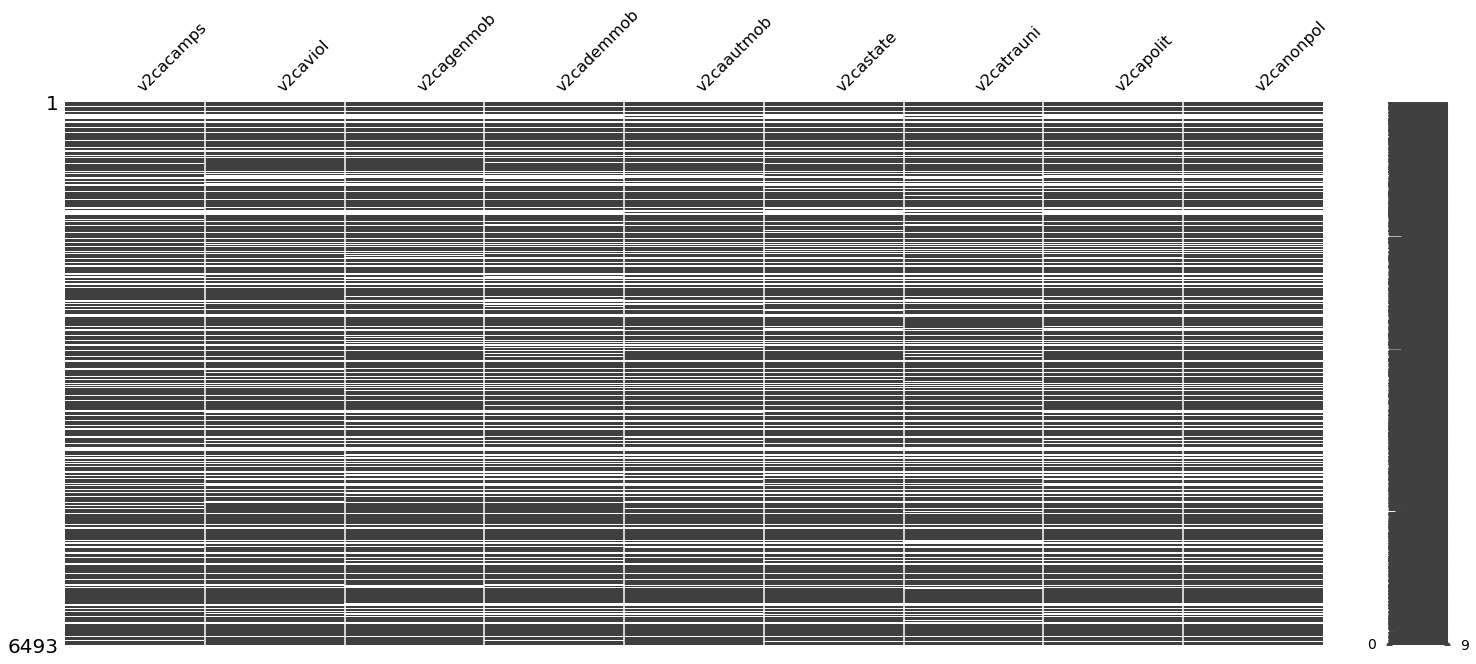

In [87]:
miss.matrix(train_X)

In [88]:
train_X

,,v2cacamps,v2caviol,v2cagenmob,v2cademmob,v2caautmob,v2castate,v2catrauni,v2capolit,v2canonpol
country_name,year,,,,,,,,,
Mexico,1973,-0.788,1.049,0.543,1.710,1.994,1.028,0.138,-0.730,-0.470
Oman,1986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Guinea,1970,2.287,0.687,-0.406,-1.418,1.584,2.498,-1.059,-0.791,0.887
Turkmenistan,1999,-1.938,-2.410,-1.500,-2.400,1.767,0.834,-2.103,-1.479,-1.674
Papua New Guinea,1996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
Finland,2000,-1.632,-1.284,-1.276,NaN,-1.840,-2.516,NaN,1.620,2.876
Tanzania,2018,-0.620,-1.041,-0.454,0.004,0.538,1.172,0.216,1.425,0.677
Bolivia,2000,-1.346,-0.724,0.611,-0.531,0.332,-1.795,1.789,0.200,1.115


In [89]:
train_X.dropna(inplace=True)

In [90]:
train_X.describe()

,v2cacamps,v2caviol,v2cagenmob,v2cademmob,v2caautmob,v2castate,v2catrauni,v2capolit,v2canonpol
count,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000,4242.000000
mean,-0.281381,-0.297330,-0.206315,-0.375581,-0.378801,-0.097031,0.451091,0.364141,0.497884
std,1.338783,1.386784,1.269520,1.309998,1.289777,1.467630,1.402762,1.291421,1.148749
min,-3.527000,-3.065000,-3.200000,-2.584000,-2.172000,-2.979000,-2.802000,-2.791000,-2.894000
25%,-1.386000,-1.392250,-1.159750,-1.438000,-1.441000,-1.271000,-0.463000,-0.493000,-0.227000
50%,-0.248000,-0.403000,-0.263000,-0.555000,-0.668000,-0.242000,0.694000,0.476000,0.611000
75%,0.669000,0.661000,0.731250,0.612000,0.512000,1.122000,1.369000,1.263000,1.317000
max,3.816000,3.698000,3.547000,3.691000,3.809000,3.435000,3.722000,3.448000,3.645000


## Make edits to full model

In [91]:
strife.dropna(inplace = True)

# Model

In [93]:
# split strife again
y = strife["backsliding"]
X = strife.drop(columns="backsliding")
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=202011)

In [94]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=1234)

# Set preprocess equal to Min Max Scaler to keep our variable distributions
preprocess = pp.MinMaxScaler()

In [95]:
# Build the modeling pipeline
pipe = Pipeline(steps=[('pre_process', preprocess),('model',None)])

search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators, max depth, and max features tuning param
    {'model' : [RF()],
    'model__max_depth':[6,7,8],
    'model__n_estimators':[500,1000,1500],
    'model__max_features': [5,10,15]},
    
]

# Grid Search to find the best parameters. The metric used for evaluation is ROC AUC
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

# fit the data with the model
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=8,
                                                           max_features=5,
                                                           n_estimators=500)],
                          'model__max_depth': [6, 7, 8],
                          'model__max_features': [5, 10, 15],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [96]:
#this is our out of sample AUC score
search.best_score_ 

0.7593319720256609

In [ ]:
# now what happens if we try on the test data
